In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

from math import sqrt


from torchdiffeq import odeint
from torch.func import jacrev

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [226]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = np.concatenate(
        [init_dim * np.arange(n_tile) + i for i in range(init_dim)]
    )
    order_index = torch.LongTensor(order_index).to(a).long()
    return torch.index_select(a, dim, order_index)


def distance_vectors(x, remove_diagonal=True):
    r = tile(x.unsqueeze(2), 2, x.shape[1])
    r = r - r.permute([0, 2, 1, 3])
    if remove_diagonal:
        r = r[:, torch.eye(x.shape[1], x.shape[1]) == 0].view(
            -1, x.shape[1], x.shape[1] - 1, x.shape[2]
        )
    return r

def distances_from_vectors(r, eps=1e-6):
    """
    Computes the all-distance matrix from given distance vectors.
    
    Parameters
    ----------
    r : torch.Tensor
        Matrix of all distance vectors r.
        Tensor of shape `[n_batch, n_particles, n_other_particles, n_dimensions]`
    eps : Small real number.
        Regularizer to avoid division by zero.
    
    Returns
    -------
    d : torch.Tensor
        All-distance matrix d.
        Tensor of shape `[n_batch, n_particles, n_other_particles]`.
    """
    return (r.pow(2).sum(dim=-1) + eps).sqrt()


In [232]:
from typing import Union, Optional, Sequence
from collections.abc import Sequence as _Sequence
import warnings

class Energy(torch.nn.Module):

    def __init__(self, dim: Union[int, Sequence[int], Sequence[Sequence[int]]], **kwargs):

        super().__init__(**kwargs)
        self._event_shapes = _parse_dim(dim)

    @property
    def dim(self):
        if len(self._event_shapes) > 1:
            raise ValueError(
                "This energy instance is defined for multiple events."
                "Therefore there exists no coherent way to define the dimension of an event."
                "Consider using Energy.event_shapes instead."
            )
        elif len(self._event_shapes[0]) > 1:
            warnings.warn(
                "This Energy instance is defined on multidimensional events. "
                "Therefore, its Energy.dim is distributed over multiple tensor dimensions. "
                "Consider using Energy.event_shape instead.",
                UserWarning,
            )
        return int(torch.prod(torch.tensor(self.event_shape, dtype=int)))

    @property
    def event_shape(self):
        if len(self._event_shapes) > 1:
            raise ValueError(
                "This energy instance is defined for multiple events."
                "Therefore therefore there exists no single event shape."
                "Consider using Energy.event_shapes instead."
            )
        return self._event_shapes[0]

    @property
    def event_shapes(self):
        return self._event_shapes

    def _energy(self, *xs, **kwargs):
        raise NotImplementedError()

    def energy(self, *xs, temperature=1.0, **kwargs):
        assert len(xs) == len(
            self._event_shapes
        ), f"Expected {len(self._event_shapes)} arguments but only received {len(xs)}"
        batch_shape = xs[0].shape[: -len(self._event_shapes[0])]
        for i, (x, s) in enumerate(zip(xs, self._event_shapes)):
            assert x.shape[: -len(s)] == batch_shape, (
                f"Inconsistent batch shapes."
                f"Input at index {i} has batch shape {x.shape[:-len(s)]}"
                f"however input at index 0 has batch shape {batch_shape}."
            )
            assert (
                x.shape[-len(s) :] == s
            ), f"Input at index {i} as wrong shape {x.shape[-len(s):]} instead of {s}"
        return self._energy(*xs, **kwargs) / temperature

    def force(
        self,
        *xs: Sequence[torch.Tensor],
        temperature: float = 1.0,
        ignore_indices: Optional[Sequence[int]] = None,
        no_grad: Union[bool, Sequence[int]] = False,
        **kwargs,
    ):
        if ignore_indices is None:
            ignore_indices = []

        with torch.enable_grad():
            forces = []
            requires_grad_states = [x.requires_grad for x in xs]

            for i, x in enumerate(xs):
                if i not in ignore_indices:
                    x = x.requires_grad_(True)
                else:
                    x = x.requires_grad_(False)

            energy = self.energy(*xs, temperature=temperature, **kwargs)

            for i, x in enumerate(xs):
                if i not in ignore_indices:
                    if isinstance(no_grad, bool):
                        with_grad = not no_grad
                    else:
                        with_grad = i not in no_grad
                    force = -torch.autograd.grad(
                        energy.sum(), x, create_graph=with_grad,
                    )[0]
                    forces.append(force)
                    x.requires_grad_(requires_grad_states[i])
                else:
                    forces.append(None)

        forces = (*forces,)
        if len(self._event_shapes) == 1:
            forces = forces[0]
        return forces


def lennard_jones_energy_torch(r, eps=1.0, rm=1.0):
    lj = eps * ((rm / r) ** 12 - 2 * (rm / r) ** 6)
    return lj

class LennardJonesPotential(Energy):
    def __init__(
            self, dim, n_particles, eps=1.0, rm=1.0, oscillator=True, oscillator_scale=1., two_event_dims=True):
        if two_event_dims:
            super().__init__([n_particles, dim//n_particles])
        else:
            super().__init__(dim)
        self._n_particles = n_particles
        self._n_dims = dim // n_particles

        self._eps = eps
        self._rm = rm
        self.oscillator = oscillator
        self._oscillator_scale = oscillator_scale

    def _energy(self, x):
        batch_shape = x.shape[:-len(self.event_shape)]
        x = x.view(*batch_shape, self._n_particles, self._n_dims)

        dists = distances_from_vectors(
            distance_vectors(x.view(-1, self._n_particles, self._n_dims))
        )

        lj_energies = lennard_jones_energy_torch(dists, self._eps, self._rm)
        lj_energies = lj_energies.view(*batch_shape, -1).sum(dim=-1) #/ 2

        if self.oscillator:
            osc_energies = 0.5 * self._remove_mean(x).pow(2).sum(dim=(-2, -1)).view(*batch_shape)
            lj_energies = lj_energies + osc_energies * self._oscillator_scale

        return lj_energies[:, None]

    def _remove_mean(self, x):
        x = x.view(-1, self._n_particles, self._n_dims)
        return x - torch.mean(x, dim=1, keepdim=True)

    def _energy_numpy(self, x):
        x = torch.Tensor(x)
        return self._energy(x).cpu().numpy()


def _parse_dim(dim):
    if isinstance(dim, int):
        return [torch.Size([dim])]
    if _is_non_empty_sequence_of_integers(dim):
        return [torch.Size(dim)]
    elif _is_sequence_of_non_empty_sequences_of_integers(dim):
        return list(map(torch.Size, dim))
    else:
        raise ValueError(
            f"dim must be either:"
            f"\n\t- an integer"
            f"\n\t- a non-empty list of integers"
            f"\n\t- a list with len > 1 containing non-empty lists containing integers"
        )


In [228]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau=1.0, r=1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [233]:
def interatomic_dist(samples):
    n_particles = samples.shape[-2]
    # Compute the pairwise differences and distances
    distances = samples[:, None, :, :] - samples[:, :, None, :]
    distances  = distances[:, torch.triu(torch.ones((n_particles, n_particles)), diagonal=1) == 1]
 
    dist = torch.linalg.norm(distances, dim=-1)

    return dist

In [234]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

In [258]:
def lennard_jones_energy_torch(r, eps=1.0, rm=1.0):
    lj = eps * ((rm / r) ** 12 - 2 * (rm / r) ** 6)
    return lj

class LennardJonesPotential(Energy):
    def __init__(
            self, dim, n_particles, eps=1.0, rm=1.0, oscillator=True, oscillator_scale=1., two_event_dims=True):
        """Energy for a Lennard-Jones cluster

        Parameters
        ----------
        dim : int
            Number of degrees of freedom ( = space dimension x n_particles)
        n_particles : int
            Number of Lennard-Jones particles
        eps : float
            LJ well depth epsilon
        rm : float
            LJ well radius R_min
        oscillator : bool
            Whether to use a harmonic oscillator as an external force
        oscillator_scale : float
            Force constant of the harmonic oscillator energy
        two_event_dims : bool
            If True, the energy expects inputs with two event dimensions (particle_id, coordinate).
            Else, use only one event dimension.
        """
        if two_event_dims:
            super().__init__([n_particles, dim//n_particles])
        else:
            super().__init__(dim)
        self._n_particles = n_particles
        self._n_dims = dim // n_particles

        self._eps = eps
        self._rm = rm
        self.oscillator = oscillator
        self._oscillator_scale = oscillator_scale

    def _energy(self, x):
        batch_shape = x.shape[:-len(self.event_shape)]
        x = x.view(*batch_shape, self._n_particles, self._n_dims)

        dists = distances_from_vectors(
            distance_vectors(x.view(-1, self._n_particles, self._n_dims))
        )

        lj_energies = lennard_jones_energy_torch(dists, self._eps, self._rm)
        lj_energies = lj_energies.view(*batch_shape, -1).sum(dim=-1) #/ 2

        if self.oscillator:
            osc_energies = 0.5 * self._remove_mean(x).pow(2).sum(dim=(-2, -1)).view(*batch_shape)
            lj_energies = lj_energies + osc_energies * self._oscillator_scale

        return lj_energies[:, None]

    def _remove_mean(self, x):
        x = x.view(-1, self._n_particles, self._n_dims)
        return x - torch.mean(x, dim=1, keepdim=True)

    def _energy_numpy(self, x):
        x = torch.Tensor(x)
        return self._energy(x).cpu().numpy()
    
    def _log_prob(self, x):
        return - self._energy(x)


In [259]:
target = LennardJonesPotential(n_nodes*dim, n_nodes, eps=1., rm=1, oscillator_scale=1, two_event_dims=False)

In [260]:
data_load = np.load("data/all_data_LJ13-2.npy", allow_pickle=True)
data_load = torch.from_numpy(remove_mean(data_load, 13, 3))
data = data_load[:len(data_load)//2]
data_holdout = data_load[len(data_load)//2:].to(device)

In [261]:
from math import log

energies_data = - target._log_prob(data_holdout).detach().cpu()
energies_data_wrong = -log_prob(data_holdout).detach().cpu()

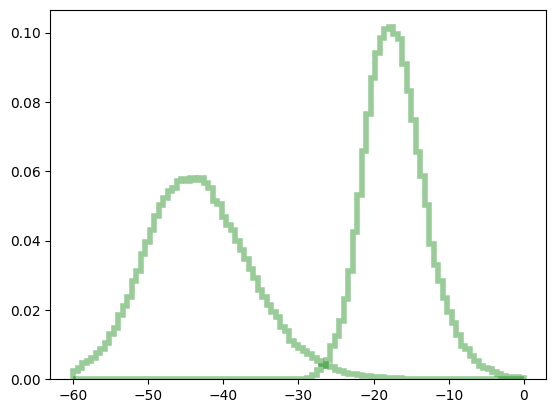

In [262]:
plt.hist(energies_data.squeeze(), bins=100, density=True, range=(-60, 0), alpha=0.4, color="g", histtype='step', linewidth=4, 
         label="test data");

plt.hist(energies_data_wrong.squeeze(), bins=100, density=True, range=(-60, 0), alpha=0.4, color="g", histtype='step', linewidth=4, 
         label="test data");

### Helper Functions

In [164]:
from typing import Dict
from torch.distributions import constraints
import math

class MeanFreeGaussian(torch.distributions.Distribution):
    arg_constraints: Dict[str, constraints.Constraint] = {}
    def __init__(self, n_nodes, spatial_dim, scale):
        super(MeanFreeGaussian, self).__init__()
        self.spatial_dim = spatial_dim
        self.n_particles = n_nodes
        self.dim = n_nodes * spatial_dim
        self.scale = scale
    
    def log_prob(self, x):
        N, D = x.shape[-2:]

        # r is invariant to a basis change in the relevant hyperplane.
        r2 = torch.sum(x**2, dim=(-1, -2))

        # The relevant hyperplane is (N-1) * D dimensional.
        degrees_of_freedom = (N-1) * D

        # Normalizing constant and logpx are computed:
        log_normalizing_constant = -0.5 * degrees_of_freedom * math.log(2*torch.pi)
        log_px = -0.5 * r2 + log_normalizing_constant
        return log_px
    
    def sample(self, n_samples):
        centers = torch.zeros((n_samples, self.dim), device=device)
        samples = torch.normal(centers, torch.full_like(centers, fill_value=self.scale**2))
        samples = samples.reshape(-1, self.n_particles, self.spatial_dim)
        samples = samples - samples.mean(-2, keepdims=True)
        return samples


In [120]:
from abc import ABC, abstractmethod

class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass
    
    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass

    
class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        
    def g(self, t):
        return torch.sqrt(self.beta * 2 * t) #self.beta.sqrt()
    
    def h(self, t):
        return self.beta * t **2

class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min
        
    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return self.sigma_min * (self.sigma_diff ** t) * ((2 * np.log(self.sigma_diff)) ** 0.5)
        
    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

In [121]:
def clip(f, max_norm):
    norm = torch.linalg.vector_norm(f, dim=-1)
    clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
    f = f * clip_coef.unsqueeze(-1)
    return f

In [122]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

## Function Definitions

### Estimated Reward Functions

In [316]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target._log_prob(samples).squeeze()
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = target._log_prob(samples).squeeze()
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [317]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness='different', 
                      in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [318]:
def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [319]:
def estimate_grad_Rt_jensen(x, t, noise_schedule, num_mc_samples=1000):
    repeated_x = x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    
    h_t = noise_schedule.h(repeated_t).unsqueeze(-1)
        
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    
    log_rewards = log_prob(samples)
    gaussian_score = -(samples - repeated_x) / (h_t + 1e-6)
    
    return (log_rewards.unsqueeze(-1) * gaussian_score).mean(dim=0)

## SDE

### Dataset

In [320]:
# np load
# samples_all = np.load('all_data_LJ13.npy')
# samples_all = samples_all.reshape(-1, n_nodes, dim)
# samples_true = torch.tensor(samples_all[:1000], device=device)
# samples_all = sample_from_array(samples_all, n_samples)
# samples_true = torch.tensor(samples_all, device=device)
# del samples_all

In [321]:
from models.egnn import remove_mean

In [322]:
samples_all = np.load('data/all_data_LJ13-2.npy')
test_data = samples_all[len(samples_all)//2:]
test_data = sample_from_array(test_data, 1000)
del samples_all

test_data = remove_mean(test_data, n_particles=n_nodes, n_dimensions=dim)
test_data = torch.tensor(test_data, device=device)

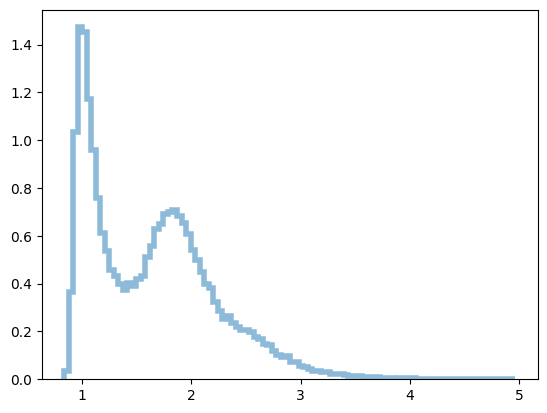

In [323]:
dist_test = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
plt.hist(dist_test.view(-1).cpu(), bins=100, label="holdout samples", alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

In [133]:
# plot_sample_hist(torch.tensor(samples_all, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# plot_sample_hist(torch.tensor(samples_all_2, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# del samples_all

### VE SDE

In [324]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = self.score(x, 1-t, self.noise_schedule)
        score = clip(score, max_norm=100)
        return self.g(t)**2 * score

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [325]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

## Training

### Dataset

In [361]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 512

noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)

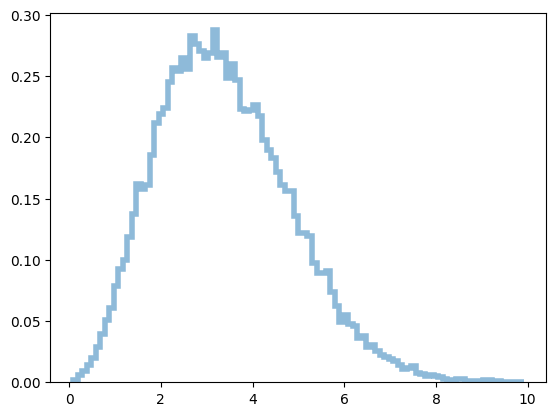

In [362]:
p1_dist = MeanFreeGaussian(13, 3, sigma)
x1_samples = p1_dist.sample(n_samples)
x1_energy = log_prob(x1_samples)

x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

### Model

In [363]:
class VEReverseSDE(torch.nn.Module):

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = self.score((1-t).unsqueeze(-1), x)
        norm = torch.linalg.vector_norm(score, dim=-1)
        max_norm = 100
        clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t)**2 * score * clip_coef[:,None]

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [364]:
from egnn_pytorch import EGNN_Network
class EGNN_Wrapper(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EGNN_Network(
            *args, **kwargs
        )

    def forward(self, x, t, *args, **kwargs):
        is_flat = x.shape[-1] != 3
        if is_flat:
            x = x.reshape(-1, 13, 3)
        if t.dim() == 0:
            t = t[None].repeat(x.shape[0])
        if t.shape[0] != x.shape[0] and t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        t_discrete = torch.bucketize(t, boundaries = torch.linspace(0, 1, 101).to(device))
        t_discrete = t_discrete[:, None].repeat(1, 13) #
        x = x - x.mean(dim=-2, keepdims=True)
        feats, coords = self.net(t_discrete, x)
        # coords = coords / coords.mean(dim=-2, keepdims=True)
        if is_flat:
            coords = coords.reshape(-1, 39)
        
        return coords

### Training

In [365]:
def reward_matching_loss_biased(vectorfield, x, t, noise_schedule, weighted=False):     
    h_t = noise_schedule.h(t.unsqueeze(1))
    
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(t.unsqueeze(-1), noisy_x)

    estimated_scores = torch.vmap(estimate_grad_Rt, in_dims=(0,0,None), randomness="different")(noisy_x, t, noise_schedule)
    estimated_scores = clip(estimated_scores, max_norm=50)
    estimated_scores = estimated_scores

    if weighted:
        lambda_t = 1/(h_t + 1e-3)
        err = torch.linalg.vector_norm((estimated_scores - pred_scores), dim=-1)**2
        return (lambda_t * err).mean()
    else:
        return ((estimated_scores - pred_scores)**2).mean()

In [366]:
from models.egnn import EGNN_dynamics

In [367]:
# vectorfield(torch.tensor([0.5]).unsqueeze(0).repeat(512, 1).to(device), x1_samples.to(device)).shape

In [368]:
buffer = SimpleBuffer(n_nodes*dim, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)

buffer.add(x1_samples.reshape(-1, n_nodes*dim), x1_energy)

Buffer not initialised, expected that checkpoint will be loaded.


In [369]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 512

noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)
p1_dist = MeanFreeGaussian(13, 3, sigma)

In [370]:
outer_epochs= 100
inner_epochs = 100

batch_size = 512

train_dataset = TensorDataset(x1_samples.reshape(-1, n_nodes*dim).clone(), x1_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

In [371]:
vectorfield = EGNN_dynamics(n_particles=n_nodes, device=device,  n_dimension=dim, hidden_nf=32,
    act_fn=torch.nn.SiLU(), n_layers=3, recurrent=True, tanh=True, attention=True, condition_time=True, agg='sum')

opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-3)
weighted = True

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 22.464764
Epoch 49 | Loss 21.846922
Epoch 98 | Loss 22.760620


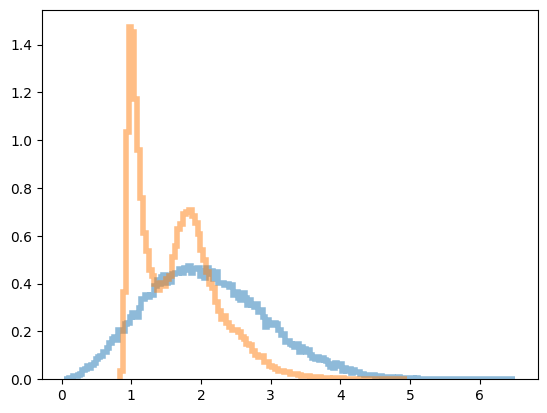

  1%|          | 1/100 [00:12<20:43, 12.56s/it]

Epoch 0 | Loss 31.183456
Epoch 49 | Loss 31.528149
Epoch 98 | Loss 27.138287


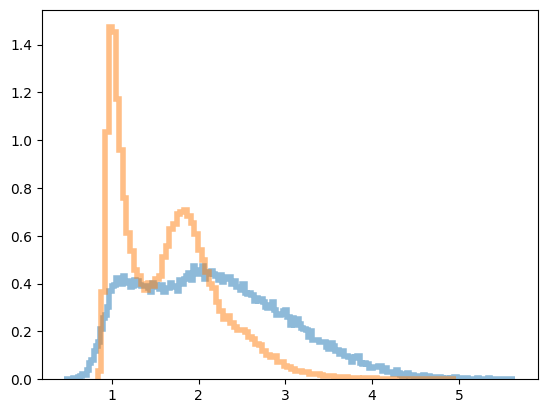

  2%|▏         | 2/100 [01:30<1:23:29, 51.12s/it]

Epoch 0 | Loss 31.005472
Epoch 49 | Loss 30.764063
Epoch 98 | Loss 31.521044


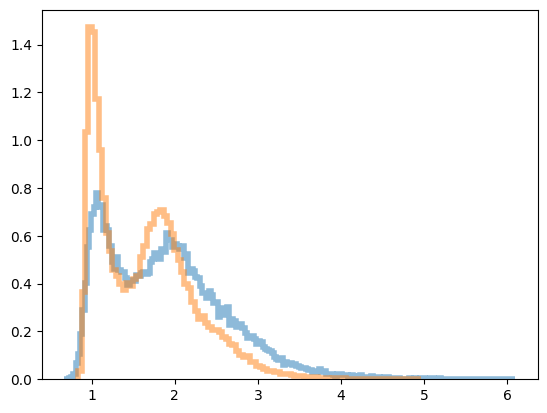

  3%|▎         | 3/100 [02:48<1:42:33, 63.44s/it]

Epoch 0 | Loss 31.089190
Epoch 49 | Loss 31.014254
Epoch 98 | Loss 33.402100


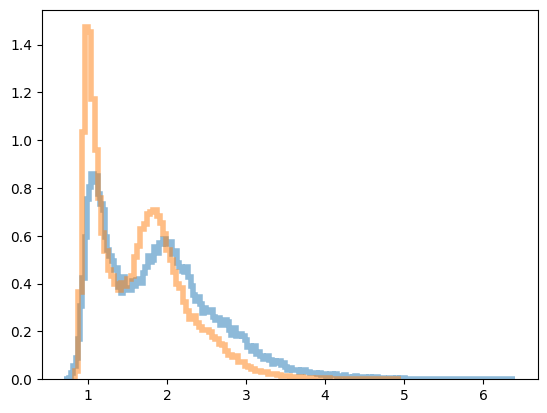

  4%|▍         | 4/100 [04:06<1:50:40, 69.18s/it]

Epoch 0 | Loss 34.602638
Epoch 49 | Loss 35.913113
Epoch 98 | Loss 31.443178


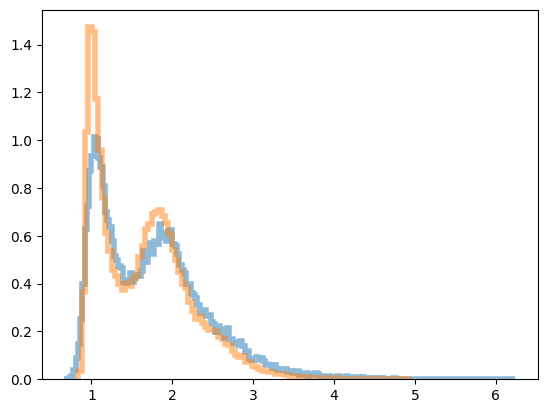

  5%|▌         | 5/100 [05:25<1:54:43, 72.46s/it]

Epoch 0 | Loss 34.813663
Epoch 49 | Loss 34.834255
Epoch 98 | Loss 34.104969


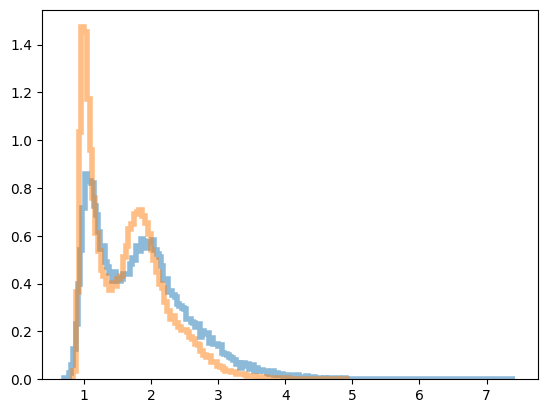

  6%|▌         | 6/100 [06:44<1:57:16, 74.86s/it]

Epoch 0 | Loss 34.718143
Epoch 49 | Loss 36.466282
Epoch 98 | Loss 36.993614


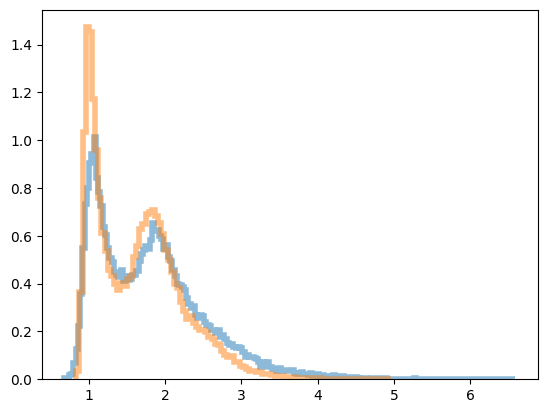

  7%|▋         | 7/100 [08:02<1:57:36, 75.87s/it]

Epoch 0 | Loss 34.472412
Epoch 49 | Loss 35.660038
Epoch 98 | Loss 34.771984


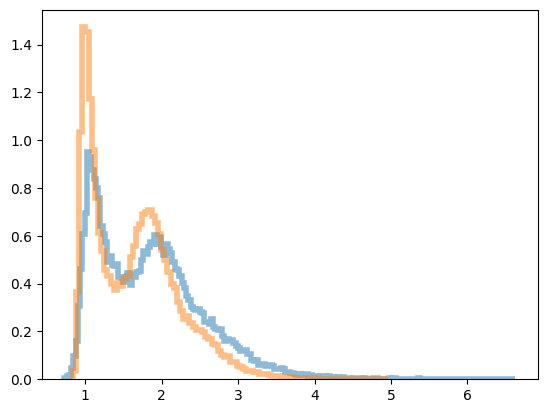

  8%|▊         | 8/100 [09:20<1:57:36, 76.70s/it]

Epoch 0 | Loss 36.522335
Epoch 49 | Loss 37.394268
Epoch 98 | Loss 35.053047


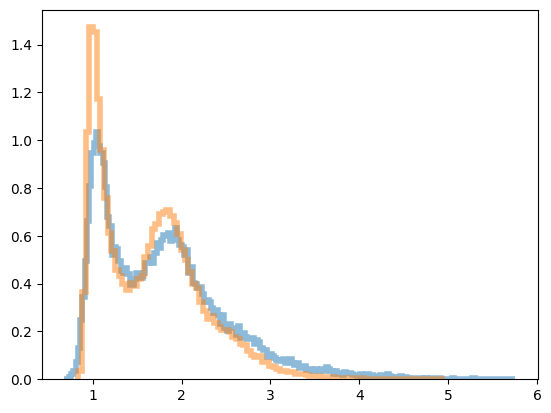

  9%|▉         | 9/100 [10:39<1:57:06, 77.21s/it]

Epoch 0 | Loss 36.838497
Epoch 49 | Loss 37.679611
Epoch 98 | Loss 33.958221


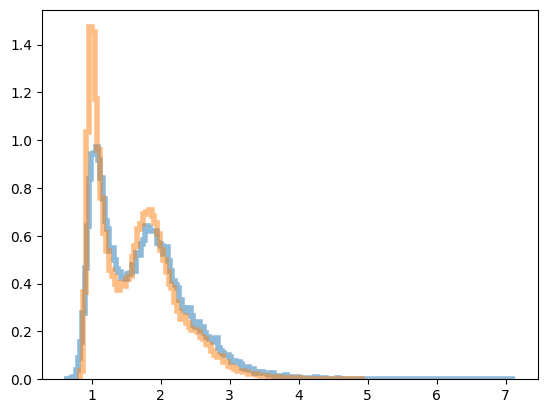

 10%|█         | 10/100 [11:57<1:56:25, 77.62s/it]

Epoch 0 | Loss 34.735222
Epoch 49 | Loss 38.047642
Epoch 98 | Loss 39.242615


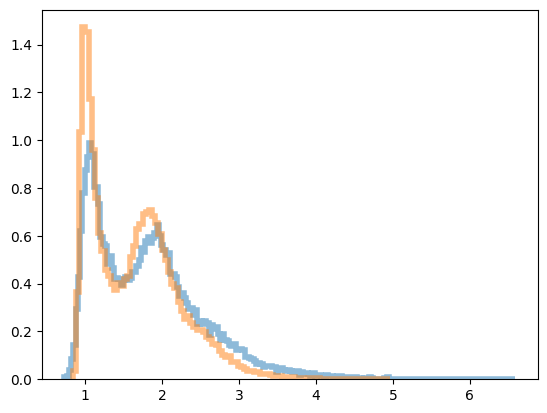

 11%|█         | 11/100 [13:16<1:55:36, 77.94s/it]

Epoch 0 | Loss 38.271408
Epoch 49 | Loss 37.983391
Epoch 98 | Loss 37.673584


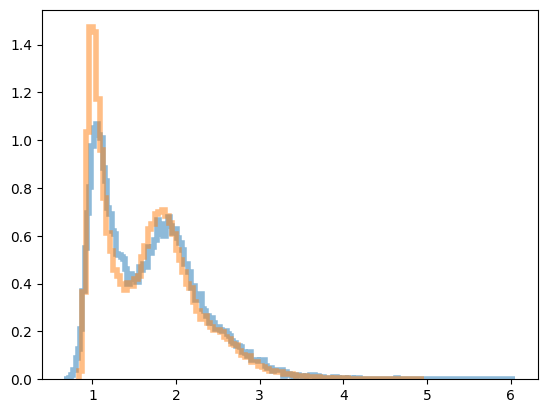

 12%|█▏        | 12/100 [14:35<1:54:50, 78.30s/it]

Epoch 0 | Loss 37.443672
Epoch 49 | Loss 37.975250
Epoch 98 | Loss 39.777824


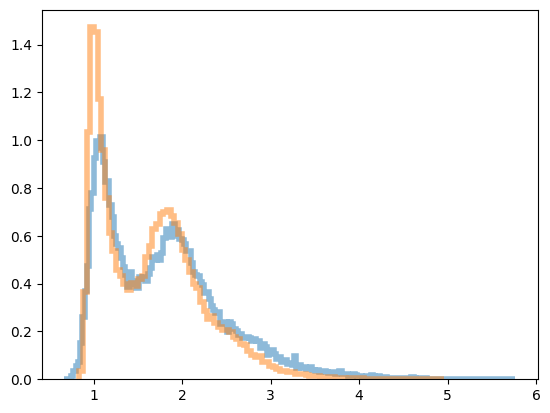

 13%|█▎        | 13/100 [15:53<1:53:21, 78.18s/it]

Epoch 0 | Loss 36.691360
Epoch 49 | Loss 37.236336
Epoch 98 | Loss 37.020939


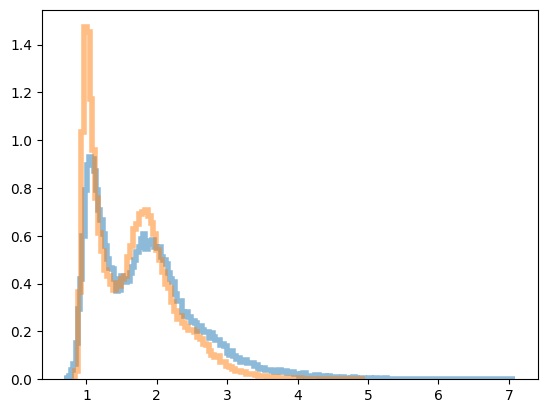

 14%|█▍        | 14/100 [17:11<1:52:08, 78.24s/it]

Epoch 0 | Loss 37.853493
Epoch 49 | Loss 36.278740
Epoch 98 | Loss 37.365509


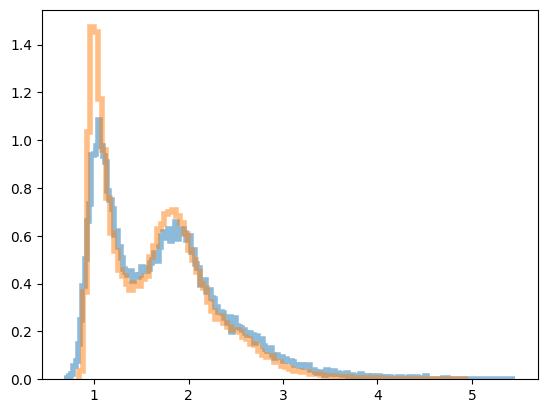

 15%|█▌        | 15/100 [18:30<1:51:05, 78.42s/it]

Epoch 0 | Loss 37.976345
Epoch 49 | Loss 37.990631
Epoch 98 | Loss 40.406826


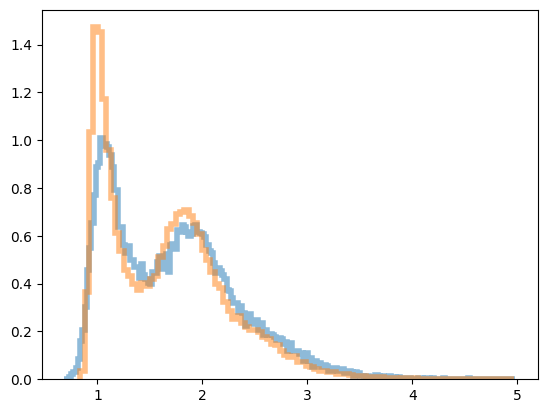

 16%|█▌        | 16/100 [19:48<1:49:34, 78.27s/it]

Epoch 0 | Loss 38.195175
Epoch 49 | Loss 37.546051
Epoch 98 | Loss 38.862545


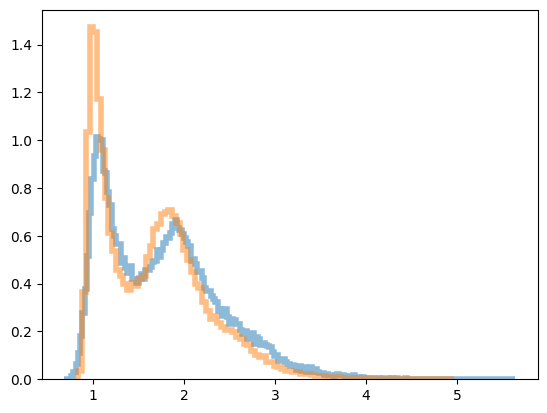

 17%|█▋        | 17/100 [21:06<1:48:15, 78.26s/it]

Epoch 0 | Loss 39.905304
Epoch 49 | Loss 40.050697
Epoch 98 | Loss 40.439316


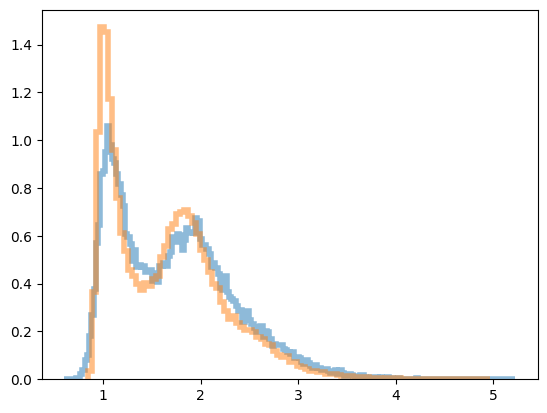

 18%|█▊        | 18/100 [22:24<1:46:50, 78.17s/it]

Epoch 0 | Loss 40.401325
Epoch 49 | Loss 39.966747
Epoch 98 | Loss 39.878922


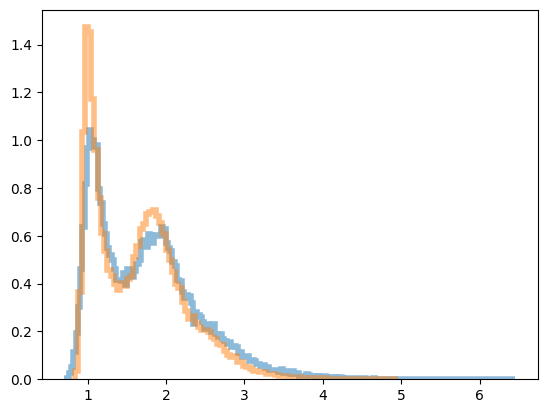

 19%|█▉        | 19/100 [23:42<1:45:24, 78.08s/it]

Epoch 0 | Loss 40.326626
Epoch 49 | Loss 40.809082
Epoch 98 | Loss 39.726967


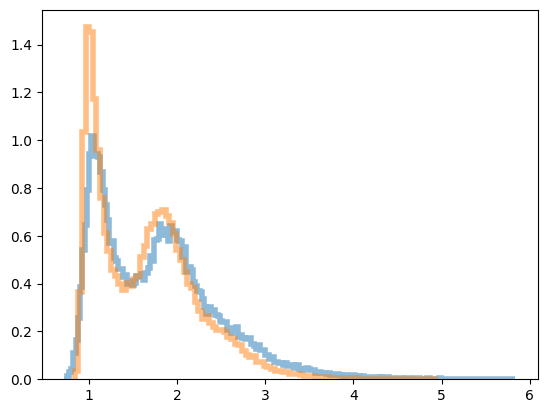

 20%|██        | 20/100 [25:01<1:44:31, 78.40s/it]

Epoch 0 | Loss 40.227646
Epoch 49 | Loss 41.728687
Epoch 98 | Loss 40.784000


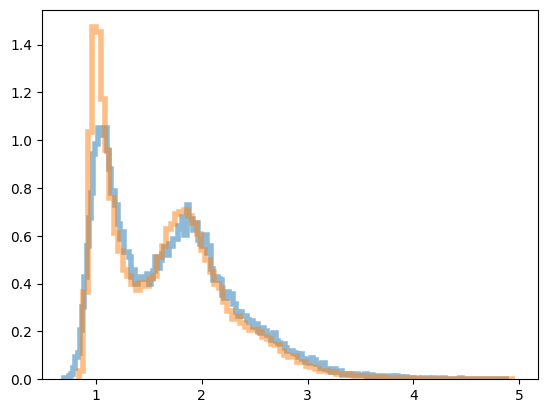

 21%|██        | 21/100 [26:20<1:43:19, 78.47s/it]

Epoch 0 | Loss 40.233299
Epoch 49 | Loss 40.535694
Epoch 98 | Loss 40.753498


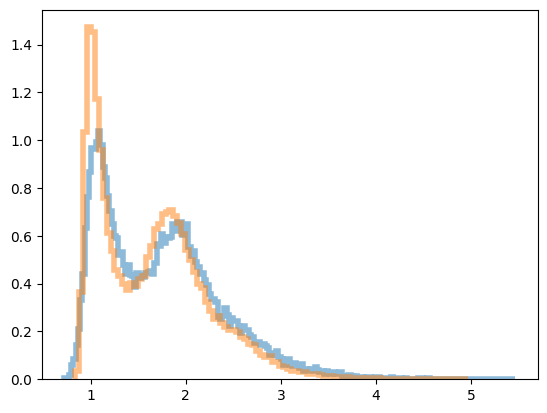

 22%|██▏       | 22/100 [27:38<1:41:49, 78.32s/it]

Epoch 0 | Loss 40.326893
Epoch 49 | Loss 39.845753
Epoch 98 | Loss 40.633904


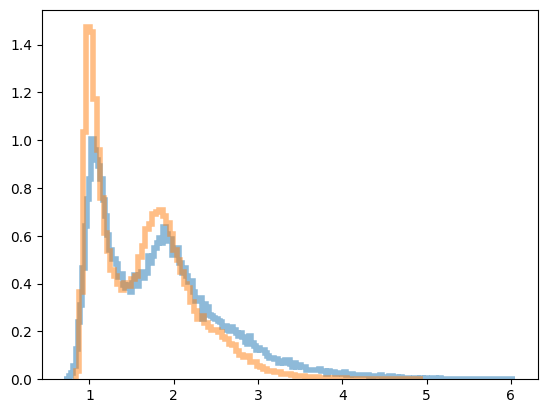

 23%|██▎       | 23/100 [28:56<1:40:25, 78.25s/it]

Epoch 0 | Loss 38.743504
Epoch 49 | Loss 41.448757
Epoch 98 | Loss 41.676014


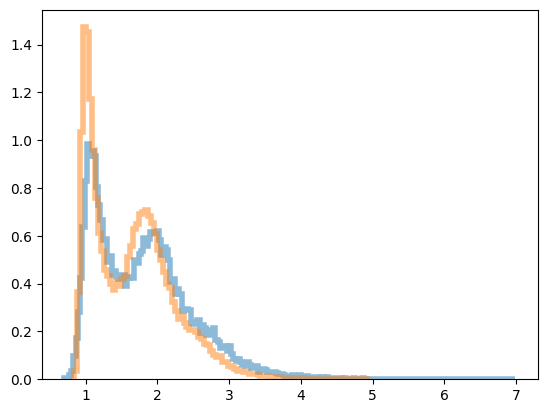

 24%|██▍       | 24/100 [30:15<1:39:27, 78.52s/it]

Epoch 0 | Loss 41.260796
Epoch 49 | Loss 38.734730
Epoch 98 | Loss 40.409657


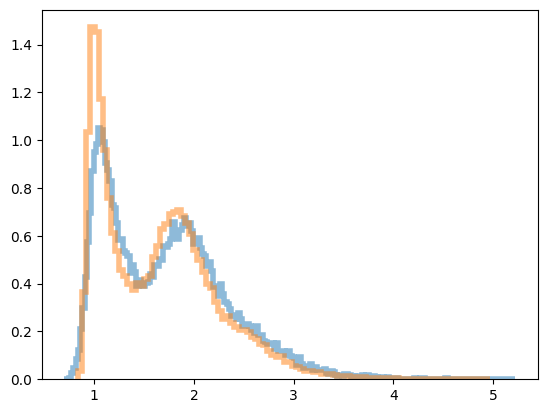

 25%|██▌       | 25/100 [31:34<1:38:12, 78.56s/it]

Epoch 0 | Loss 41.079727
Epoch 49 | Loss 40.167374
Epoch 98 | Loss 41.337547


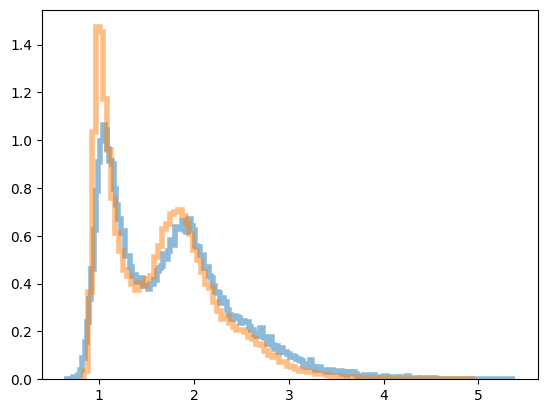

 26%|██▌       | 26/100 [32:53<1:37:16, 78.87s/it]

Epoch 0 | Loss 41.600929
Epoch 49 | Loss 40.181339
Epoch 98 | Loss 41.870087


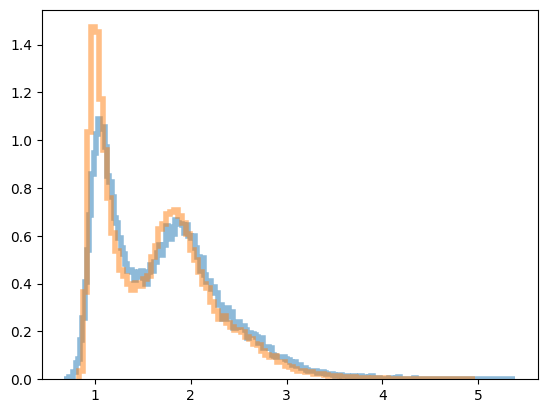

 27%|██▋       | 27/100 [34:12<1:35:55, 78.84s/it]

Epoch 0 | Loss 39.993172
Epoch 49 | Loss 40.671326
Epoch 98 | Loss 41.007229


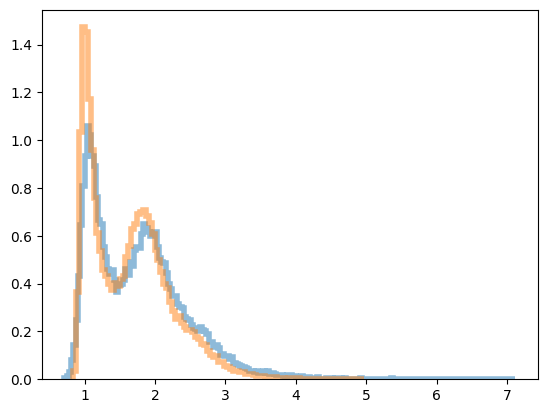

 28%|██▊       | 28/100 [35:31<1:34:26, 78.70s/it]

Epoch 0 | Loss 40.913986
Epoch 49 | Loss 41.595768
Epoch 98 | Loss 40.924618


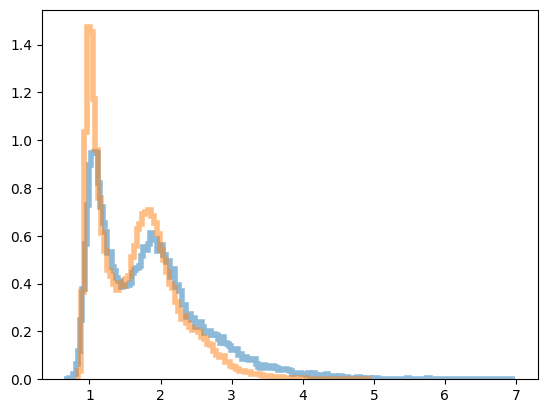

 29%|██▉       | 29/100 [36:49<1:33:11, 78.75s/it]

Epoch 0 | Loss 41.634632
Epoch 49 | Loss 40.236935
Epoch 98 | Loss 41.053009


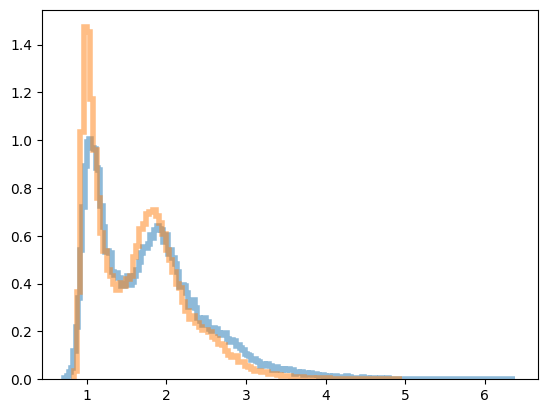

 30%|███       | 30/100 [38:07<1:31:31, 78.45s/it]

Epoch 0 | Loss 42.199554
Epoch 49 | Loss 42.031521
Epoch 98 | Loss 39.490925


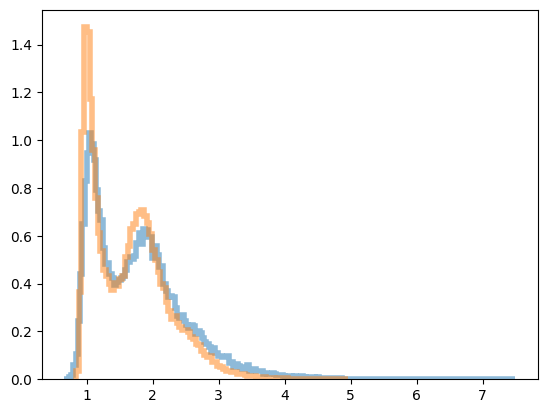

 31%|███       | 31/100 [39:26<1:30:26, 78.65s/it]

Epoch 0 | Loss 41.067616
Epoch 49 | Loss 40.555378
Epoch 98 | Loss 41.646984


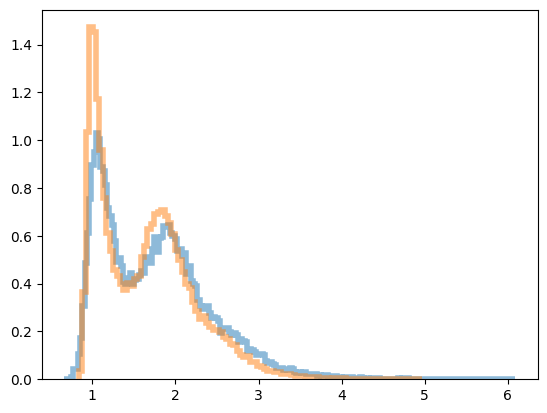

 32%|███▏      | 32/100 [40:45<1:29:14, 78.74s/it]

Epoch 0 | Loss 42.102493
Epoch 49 | Loss 42.041451
Epoch 98 | Loss 42.277180


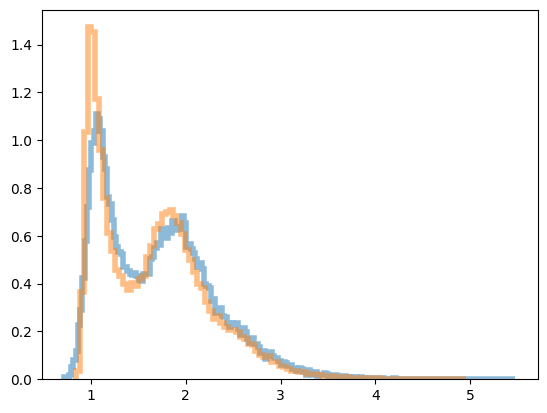

 33%|███▎      | 33/100 [42:03<1:27:39, 78.50s/it]

Epoch 0 | Loss 41.751675
Epoch 49 | Loss 39.596642


 33%|███▎      | 33/100 [43:11<1:27:40, 78.52s/it]


KeyboardInterrupt: 

In [372]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            
            t = torch.rand(len(samples), device=device)

            loss = reward_matching_loss_biased(vectorfield, samples, t, noise_schedule)
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the vector field
    # centers = torch.zeros((n_samples, n_nodes*dim), device=device)
    # x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=noise_schedule.h(1)**2))
    x1_samples = p1_dist.sample(n_samples).reshape(-1, n_nodes*dim)

    ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
    samples = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]
    samples_energy = target._log_prob(samples).detach().squeeze()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))

    plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4)
    plt.hist(dist_test.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4) 
    plt.show()

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [373]:
x1_samples = p1_dist.sample(10000).reshape(-1, n_nodes*dim)
ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
samples = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]


samples_energy = -target._log_prob(samples).detach().squeeze()
test_energy = - target._log_prob(data_holdout).detach().squeeze()

In [376]:
data_holdout.shape

torch.Size([500000, 39])

In [377]:
samples_energy.shape

torch.Size([10000])

In [378]:
min_energy = min(test_energy.min(), samples_energy.min()).cpu().item()
max_energy = max(test_energy.max(), samples_energy.max()).cpu().item()

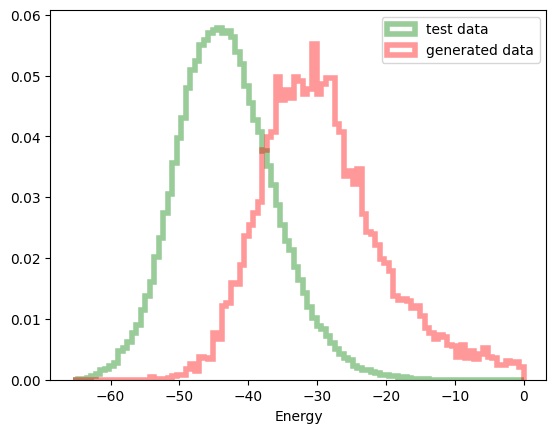

In [379]:
plt.hist(test_energy.cpu(), bins=100, density=True, alpha=0.4, range=(min_energy, 0),
        color="g", histtype='step', linewidth=4, label="test data");

plt.hist(samples_energy.cpu(), bins=100, density=True, alpha=0.4, range=(min_energy, 0),
        color="r", histtype='step', linewidth=4, label="generated data");
plt.xlabel("Energy")
plt.legend()

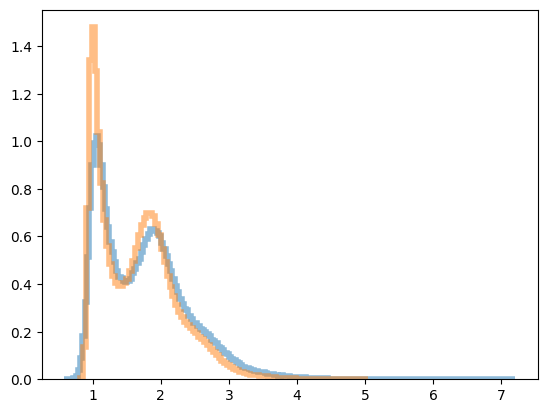

In [382]:
dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))
dist_holdout = interatomic_dist(data_holdout.reshape(-1, n_nodes, dim))
plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(dist_holdout.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4);

### Evaluation

### NLL

In [287]:
follow_estimate = False
follow_model = True
reverse_time =  False

In [296]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(n_nodes*dim).to(device), torch.eye(n_nodes*dim).to(device) * beta
    )
    return dist

In [297]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True

        if follow_estimate:
            f = estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100)
            f = clip(f, max_norm=100)
            f = -0.5 * noise_schedule.g(t)**2 * f

        else:
            f = vectorfield(t.unsqueeze(-1), x)
            # f = clip(f, max_norm=100)
            f = - 0.5 * noise_schedule.g(t)[0]**2 * f

    return f

In [298]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    if follow_model:
        def div(x):
            return torch.trace(J(x.unsqueeze(0)).squeeze())
        return div
    else:
        return lambda x: torch.trace(J(x))


def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
    else:
        dx = vecfield(x)
    
    if reverse_time:
        div = torch.zeros((x.shape[0]), device=device)
    else:
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    return dx, div

In [300]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    
    vecfield = lambda x: drift(x, t)
    if follow_model:
        def vecfield(x):
            return drift(x, torch.ones(x.shape[0]).to(device) * t)
    
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = test_data
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [301]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-47.5622, device='cuda:0')
logdetjac tensor(-15.4821, device='cuda:0')
logp1 tensor(63.0443, device='cuda:0')


In [302]:
x0_true = torch.randn((1000, n_nodes*dim), device=device) * np.sqrt(beta)
true_logp0 = p0.log_prob(x0_true.view(-1, 39))
print("true_logp0", true_logp0.mean())

true_logp0 tensor(-63.3848, device='cuda:0')


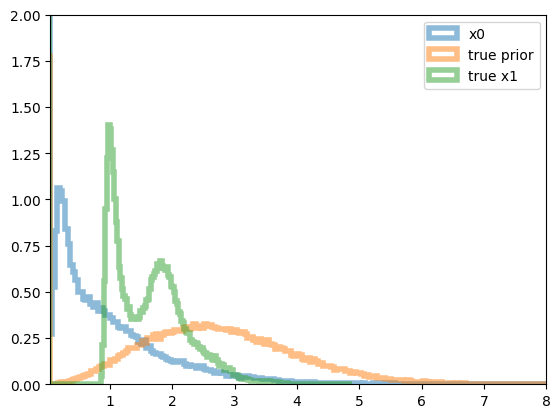

In [303]:
x0 = x0.reshape(-1, n_nodes, dim)
x0_dists = interatomic_dist(x0)
x0_true_dists = interatomic_dist(x0_true.reshape(-1, n_nodes, dim)).detach()
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

plt.hist(x0_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, 
         histtype='step', linewidth=4, label='x0')
plt.hist(x0_true_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true prior') 
plt.hist(test_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true x1')
plt.xlim(0.05, 8)
plt.ylim(0, 2.0)
plt.legend()
plt.show()